In [ ]:
#split data into 20 categories (10-90% percentile for positive and negative so 10x2) based on SMA 1 minute from past 20 days, 
#then within each SMA category, separate into quartiles based on cumulative volume in 1 minute
#calculate the mean and std of the edge in each case

import pandas as pd
import datetime
import numpy as np
from tqdm import tqdm_notebook
from datetime import datetime,timedelta
import os
from timeit import default_timer as timer
from scipy import stats
from sklearn import linear_model
path='/Users/hudsonyeo/Desktop/Python/leo/data/day/fu'
os.chdir('/Users/hudsonyeo/Desktop/Python/leo/data/day/SR')
file_list=os.listdir(path)
file_list.sort()

In [3]:
file_list

['.DS_Store',
 '2019.01.02.csv',
 '2019.01.03.csv',
 '2019.01.04.csv',
 '2019.01.07.csv',
 '2019.01.08.csv',
 '2019.01.09.csv',
 '2019.01.10.csv',
 '2019.01.11.csv',
 '2019.01.14.csv',
 '2019.01.15.csv',
 '2019.01.16.csv',
 '2019.01.17.csv',
 '2019.01.18.csv',
 '2019.01.21.csv',
 '2019.01.22.csv',
 '2019.01.23.csv',
 '2019.01.24.csv',
 '2019.01.25.csv',
 '2019.01.28.csv',
 '2019.01.29.csv',
 '2019.01.30.csv',
 '2019.01.31.csv',
 '2019.02.01.csv',
 '2019.02.11.csv',
 '2019.02.12.csv',
 '2019.02.13.csv',
 '2019.02.14.csv',
 '2019.02.15.csv',
 '2019.02.18.csv',
 '2019.02.19.csv',
 '2019.02.20.csv',
 '2019.02.21.csv',
 '2019.02.22.csv',
 '2019.02.25.csv',
 '2019.02.26.csv',
 '2019.02.27.csv',
 '2019.02.28.csv',
 '2019.03.01.csv',
 '2019.03.04.csv',
 '2019.03.05.csv',
 '2019.03.06.csv',
 '2019.03.07.csv',
 '2019.03.08.csv',
 '2019.03.11.csv',
 '2019.03.12.csv',
 '2019.03.13.csv',
 '2019.03.14.csv',
 '2019.03.15.csv',
 '2019.03.18.csv',
 '2019.03.19.csv',
 '2019.03.20.csv',
 '2019.03.21.csv'

In [5]:
class categorise():
    def __init__(self):
        self.threshold=[]
        self.percentiles=[25,50,75]
        
    def fit(self,array):
        positive=array[array>0]
        negative=array[array<0]
        self.threshold.append(np.percentile(negative,self.percentiles))   
        self.threshold.append(np.percentile(positive,self.percentiles))
     
    def return_quartile(self,array):
        temp=[]
        for i in array:
            if i>=0:
                if i<self.threshold[1][0]:
                    temp.append(5)
                elif i<self.threshold[1][1]:
                    temp.append(6)
                elif i<self.threshold[1][2]:
                    temp.append(7)
                else:
                    temp.append(8)
            if i<0:
                if i>self.threshold[0][2]:
                    temp.append(4)
                elif i>self.threshold[0][1]:
                    temp.append(3)
                elif i>self.threshold[0][0]:
                    temp.append(2)
                else:
                    temp.append(1)
        return np.asarray(temp)
    
class categorise_simple():
    def __init__(self):
        self.threshold=[]
        self.percentiles=[25,50,75]
        
    def fit(self,array):
        self.threshold.append(np.percentile(array,self.percentiles))
     
    def return_quartile(self,array):
        temp=[]
        for i in array:
                if i<self.threshold[0][0]:
                    temp.append(1)
                elif i<self.threshold[0][1]:
                    temp.append(2)
                elif i<self.threshold[0][2]:
                    temp.append(3)
                else:
                    temp.append(4)
        return np.asarray(temp)    
    
class categorise_10():
    def __init__(self):
        self.threshold=[]
        self.percentiles=[10,20,30,40,50,60,70,80,90]
        
    def fit(self,array):
        positive=array[array>0]
        negative=array[array<0]
        self.threshold.append(np.percentile(negative,self.percentiles))   
        self.threshold.append(np.percentile(positive,self.percentiles))
     
    def return_quartile(self,array):
        temp=[]
        for i in array:
            if i>=0:
                if i<self.threshold[1][0]:
                    temp.append(11)
                elif i<self.threshold[1][1]:
                    temp.append(12)
                elif i<self.threshold[1][2]:
                    temp.append(13)
                elif i<self.threshold[1][3]:
                    temp.append(14)
                elif i<self.threshold[1][4]:
                    temp.append(15)
                elif i<self.threshold[1][5]:
                    temp.append(16)
                elif i<self.threshold[1][6]:
                    temp.append(17)
                elif i<self.threshold[1][7]:
                    temp.append(18)
                elif i<self.threshold[1][8]:
                    temp.append(19)                    
                else:
                    temp.append(20)
            if i<0:
                if i<self.threshold[0][0]:
                    temp.append(1)
                elif i<self.threshold[0][1]:
                    temp.append(2)
                elif i<self.threshold[0][2]:
                    temp.append(3)
                elif i<self.threshold[0][3]:
                    temp.append(4)
                elif i<self.threshold[0][4]:
                    temp.append(5)
                elif i<self.threshold[0][5]:
                    temp.append(6)
                elif i<self.threshold[0][6]:
                    temp.append(7)
                elif i<self.threshold[0][7]:
                    temp.append(8)
                elif i<self.threshold[0][8]:
                    temp.append(9)                    
                else:
                    temp.append(10)
        return np.asarray(temp)    

In [27]:
def calc_smart_price(dataset):
    data=dataset[:]
    
    #to combat the limit up event, where price is set to 0. 
    rows=(data.loc[:,'BidPrice1']==0) #count rows of bid price equal 0
    if (np.any(rows)): #if there is such a row
        data.at[rows,'BidPrice1']=data.loc[rows,'AskPrice1'] #for that row, assign ask price to it
    rows=(data.loc[:,'AskPrice1']==0) #do the same for ask price
    if (np.any(rows)):
        data.at[rows,'AskPrice1']=data.loc[rows,'BidPrice1'] 
        
    data['smart_price']=data.loc[:,'BidPrice1']*data.loc[:,'AskVol1']+data.loc[:,'AskPrice1']*data.loc[:,'BidVol1']
    data.at[:,'smart_price']=data.loc[:,'smart_price']/(data.loc[:,['BidVol1','AskVol1']].sum(axis=1))  
    return data

def calc_present_vol(dataset):
    data=dataset[:]
    data['current_vol']=data.loc[:,'Volume'].diff().fillna(0)/2
    return data

def calc_future_price(dataset,time_ahead=30,time_index=44):
    data=dataset[:]
    future_price=[]
    length=len(data)
    for i in range(len(data)):
        current_time=data[i,time_index]+timedelta(seconds=time_ahead)
        #print(data[i,44])
        j=0
        #print(current_time)
        while((i+j)<length and current_time>data[(i+j),time_index]):
            j+=1
        if (i+j)<length:
            future_price.append(data[(i+j),-2]) #51 is the index for smart price            
        else:
            future_price.append(np.nan)
    future_price=np.asarray(future_price)
    future_price=np.expand_dims(future_price,axis=1)
    return np.concatenate((data,future_price),axis=1)


def calc_edge(dataset):
    data=dataset.copy()
    temp=data[:,-1]-data[:,-3]
    temp=np.expand_dims(temp,axis=1)
    return np.concatenate((data,temp),axis=1)

def set_index(dataset,time_index=44):
    data=dataset[:]
    index=data[:,time_index]
    new_index=[]
    for j in range(len(index)):
        i=str(index[j]*1000)
        if len(i)==11:
            i='0'+i
        i=i[:-10]+':'+i[-10:]
        i=i[:-8]+':'+i[-8:]
        i=i[:-6]+':'+i[-6:]
        new_index.append(datetime.strptime(i,"%H:%M:%S:%f"))
    data[:,time_index]=new_index
    return data

def calc_sma_fast(dataset,duration=1,time_index=44): #faster way to calculate SMA, 0.05 seconds for 5000 rows
    data=dataset[:]
    sma_values=[] 
    smart_sum=np.cumsum(data[:,-4]) #smart price column is -4
    for i in range(len(data)):
        last_time=data[i,time_index]-timedelta(minutes=duration)
        j=220*duration#4x60=240
        while(i-j>0 and data[i-j,time_index]>last_time):
            j+=1
        if (i-j>=0):
            sma=(smart_sum[i]-smart_sum[i-j])/(j)
            sma_values.append(sma)
        else:
            sma=smart_sum[i]/(i+1)
            sma_values.append(sma)

    sma_values=np.asarray(sma_values)
    sma_values=data[:,-4]-sma_values
    sma_values=np.expand_dims(sma_values,axis=1)
    return np.concatenate((data,sma_values),axis=1)  

def calc_past_vol(dataset,duration=1,time_index=44): #
    data=dataset[:].copy()
    vol_values=[] 
    vol_sum=np.cumsum(data[:,-4])
    for i in range(len(data)):
        last_time=data[i,time_index]-timedelta(minutes=duration)
        j=220*duration#4x60=240
        while(i-j>0 and data[i-j,time_index]>last_time):
            j+=1
        if (i-j>=0):
            vol=(vol_sum[i]-vol_sum[i-j])
            vol_values.append(vol)
        else:
            vol=vol_sum[i]
            vol_values.append(vol)
    vol_values=np.asarray(vol_values)
    vol_values=np.expand_dims(vol_values,axis=1)
    return np.concatenate((data,vol_values),axis=1) 

def process(dataset,sma_duration=1,vol_duration=1,time_index=44):
    data=dataset[:]
    data=calc_smart_price(data) #new
    data=calc_present_vol(data).values #new 
    data=set_index(data,time_index=time_index) #no change
    data=calc_future_price(data,time_index=time_index) #new
    data=calc_edge(data) #new
    data=calc_sma_fast(data,duration=sma_duration,time_index=time_index) #new
    data=calc_past_vol(data,duration=vol_duration,time_index=time_index) #new
    return data


In [ ]:
df_list=[]
name_list=[]
path='/Users/hudsonyeo/Desktop/Python/leo/data/day/TA/'
for file in file_list: #read all files and add them to file_list
    if file[-3:]=='csv': #check if file is a CSV
        name_list.append(file)
        df_list.append(process(pd.read_csv(path+file),sma_duration=3))
        print(file,'read')

In [ ]:
df_path='/Users/hudsonyeo/Desktop/Python/leo/data/day/TA/results/'

final_df=pd.DataFrame()    

for i in range(len(df_list)): #for each 20 day rolling window
    if i<19:
        continue
    print(name_list[i])

    #get -19 day
    sma=df_list[i-19][:,55].copy() #column for SMA
    vol=df_list[i-19][:,56].copy()
    
    #get -18 to 0 day (19 days in total)
    for k in range((i-18),i+1): #get 20 day moving averages
        sma=np.concatenate((sma,df_list[k][:,55].copy()))
        vol=np.concatenate((vol,df_list[k][:,56].copy()))
        
    cat_sma=categorise_10()
    cat_sma.fit(sma) #calculate quartile thresholds for past 20 days
    
    #get categories for past 20 days
    cat_sma_20=(cat_sma.return_quartile(sma))   

    #get x,y for regression
    x_today=df_list[i][:,55].copy().astype(float) #column for SMA     
    y_today=df_list[i][:,54].copy().astype(float) #column for edge
    
    vol_today=df_list[i][:,56].copy()    
    #removing all NA
    isnum=(~np.isnan(x_today)) & (~np.isnan(y_today))
    #get categories of today's sma  
    cat_x_today=cat_sma.return_quartile(x_today)
    
    
    reg_result={}
    reg_result['date']=name_list[i]
    reg_result['total_obs']=len(x_today[isnum])   
    
    for cat in range(1,21):
        #check past 20 days quartiles and filter volume by category
        vol_fit=vol[cat_sma_20==cat].copy()

        #simple quartile categorisation
        cat_vol=categorise_simple()
        cat_vol.fit(vol_fit)
    
        
        #today's sma filter
        sma_filter_today=(cat_x_today==cat)
        #today's vol categories
        cat_vol_today=cat_vol.return_quartile(vol_today)


        for quartile in [1,2,3,4]:

            filtered= (isnum & sma_filter_today) #filtering NA and sma quartile
            filtered= filtered & (cat_vol_today==quartile) #filtering volume
            new_y=y_today[filtered].copy()

            q='ma_cat_'+str(cat)+'_vol_quartile'+str(quartile)+'_'
            if (len(new_y)!=0):

                reg_result[(q+'mean')]=np.mean(new_y)
                reg_result[(q+'std')]=np.std(new_y)
                reg_result[(q+'num_obs')]=len(new_y)

            else:

                reg_result[(q+'mean')]=np.nan
                reg_result[(q+'std')]=np.nan
                reg_result[(q+'num_obs')]='0'

    final_df=final_df.append(reg_result,ignore_index=True)                
temp=df_path+'result_10sma,6vol_1min,10min_sma,vol_mean.csv'
final_df.to_csv(temp)
print('done',temp)

In [ ]:
data=pd.read_csv('/Users/hudsonyeo/Desktop/Python/leo/data/day/fu//results/result_10sma,6vol_1min,3min_sma,vol_mean.csv')
x=[]
x_std=[]
pos=[]
num_obs=[]
for ma_cat in range(1,21):
    for vol_cat in range(1,5):
        col='ma_cat_'+str(ma_cat)+'_vol_quartile'+str(vol_cat)+'_mean'
        std=data.loc[:,col].std()
        mean=data.loc[:,col].mean()
        column=data.loc[:,col]
        x_std.append(std)
        x.append(mean)
        percentage=len(column[column>=0])/len(column)
        pos.append(percentage)  
        
        obs='ma_cat_'+str(ma_cat)+'_vol_quartile'+str(vol_cat)+'_num_obs'
        obs=data.loc[:,obs].sum()
        num_obs.append(obs)
x=np.asarray(x)
x=np.reshape(x,(20,4))
x_std=np.asarray(x_std)
x_std=np.reshape(x_std,(20,4))
pos=np.asarray(pos)
pos=np.reshape(pos,(20,4))
num_obs=np.asarray(num_obs)
num_obs=np.reshape(num_obs,(20,4))
print('mean\n',x)
print('std\n',x_std)
print('% positive\n',pos)
print('num obs\n',num_obs)

In [35]:
test=pd.read_csv('/Users/hudsonyeo/Desktop/Python/leo/data/day/fu/2019.03.13.csv')

In [ ]:
vol=test.loc[:,'Volume'].diff()/2
vol=vol.dropna()

In [ ]:
import matplotlib.pyplot as plt
plt.hist(vol,bins=50)
plt.show()

In [10]:
time_index=np.where(test.columns.values=='Time')[0][0]
time_index

4

In [36]:

processed_1=process(test[:],sma_duration=1,time_index=time_index)
processed_3=process(test[:],sma_duration=3,time_index=time_index)
processed_5=process(test[:],sma_duration=5,time_index=time_index)
processed_10=process(test[:],sma_duration=10,time_index=time_index)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

In [ ]:
edge=processed[:,-3].astype(float)
edge=edge[~np.isnan(edge)]

In [13]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(edge)
plt.show()

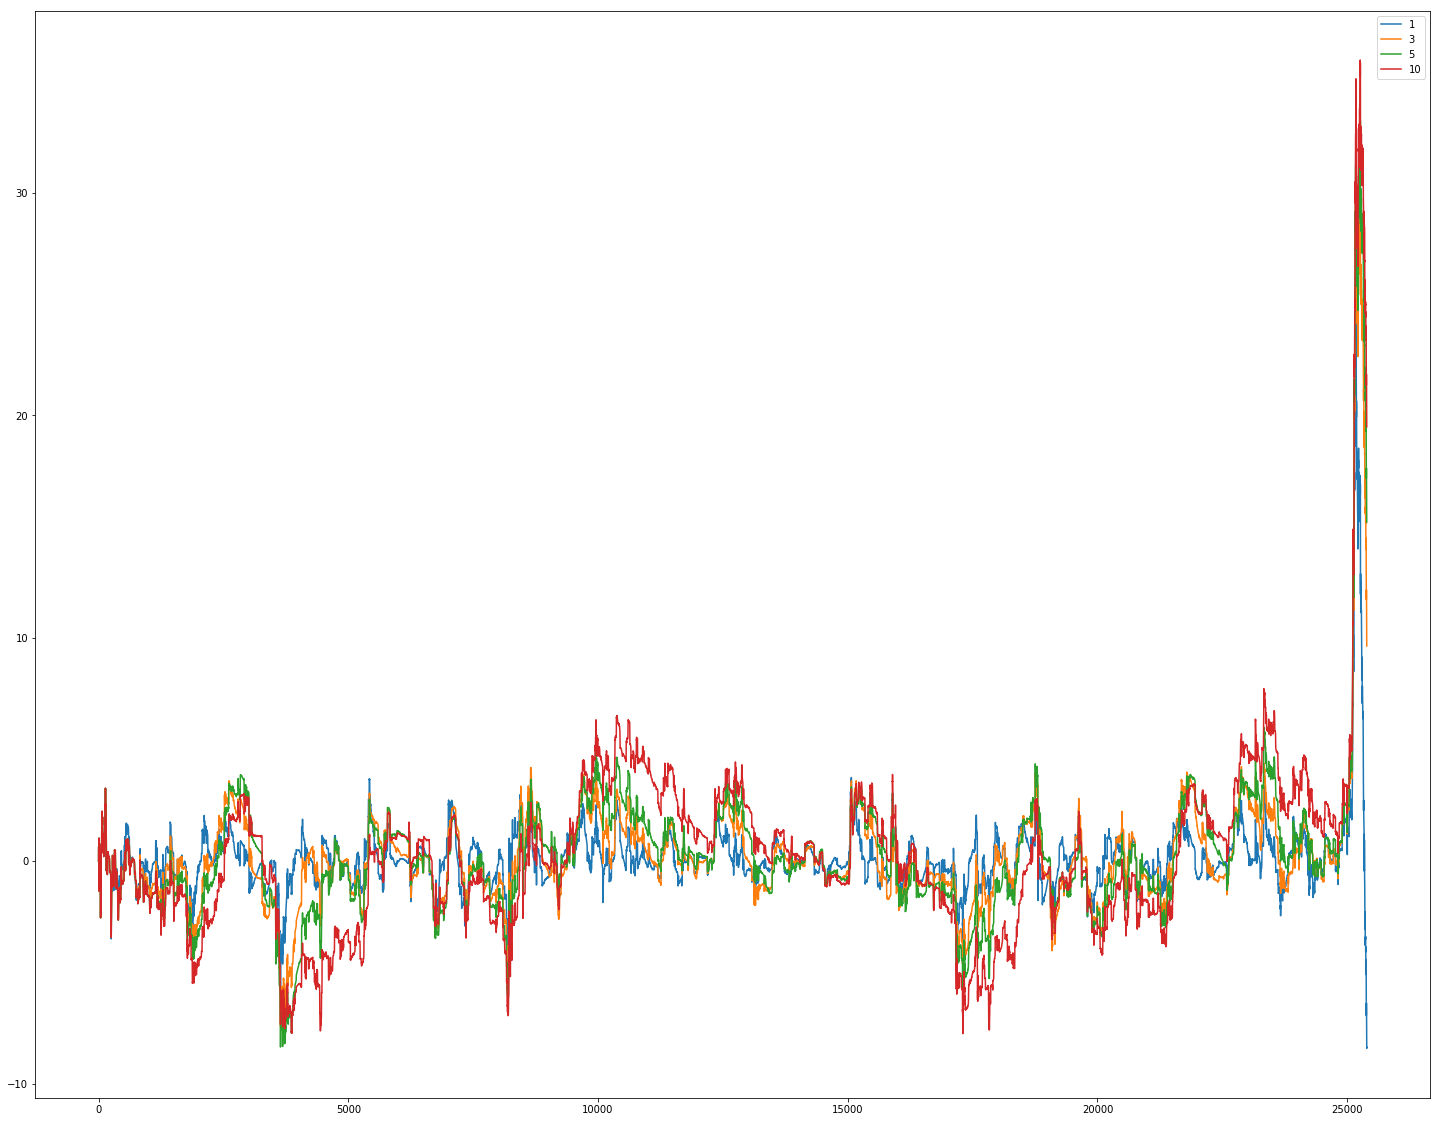

In [44]:
plt.figure(figsize=(25,20))
plt.plot(processed_1[:,-2],label='1')
plt.plot(processed_3[:,-2],label='3')
plt.plot(processed_5[:,-2],label='5')
plt.plot(processed_10[:,-2],label='10')
plt.legend()
#plt.show()
plt.savefig('/Users/hudsonyeo/Desktop/Python/leo/data/day/fu/results/second/result.png')

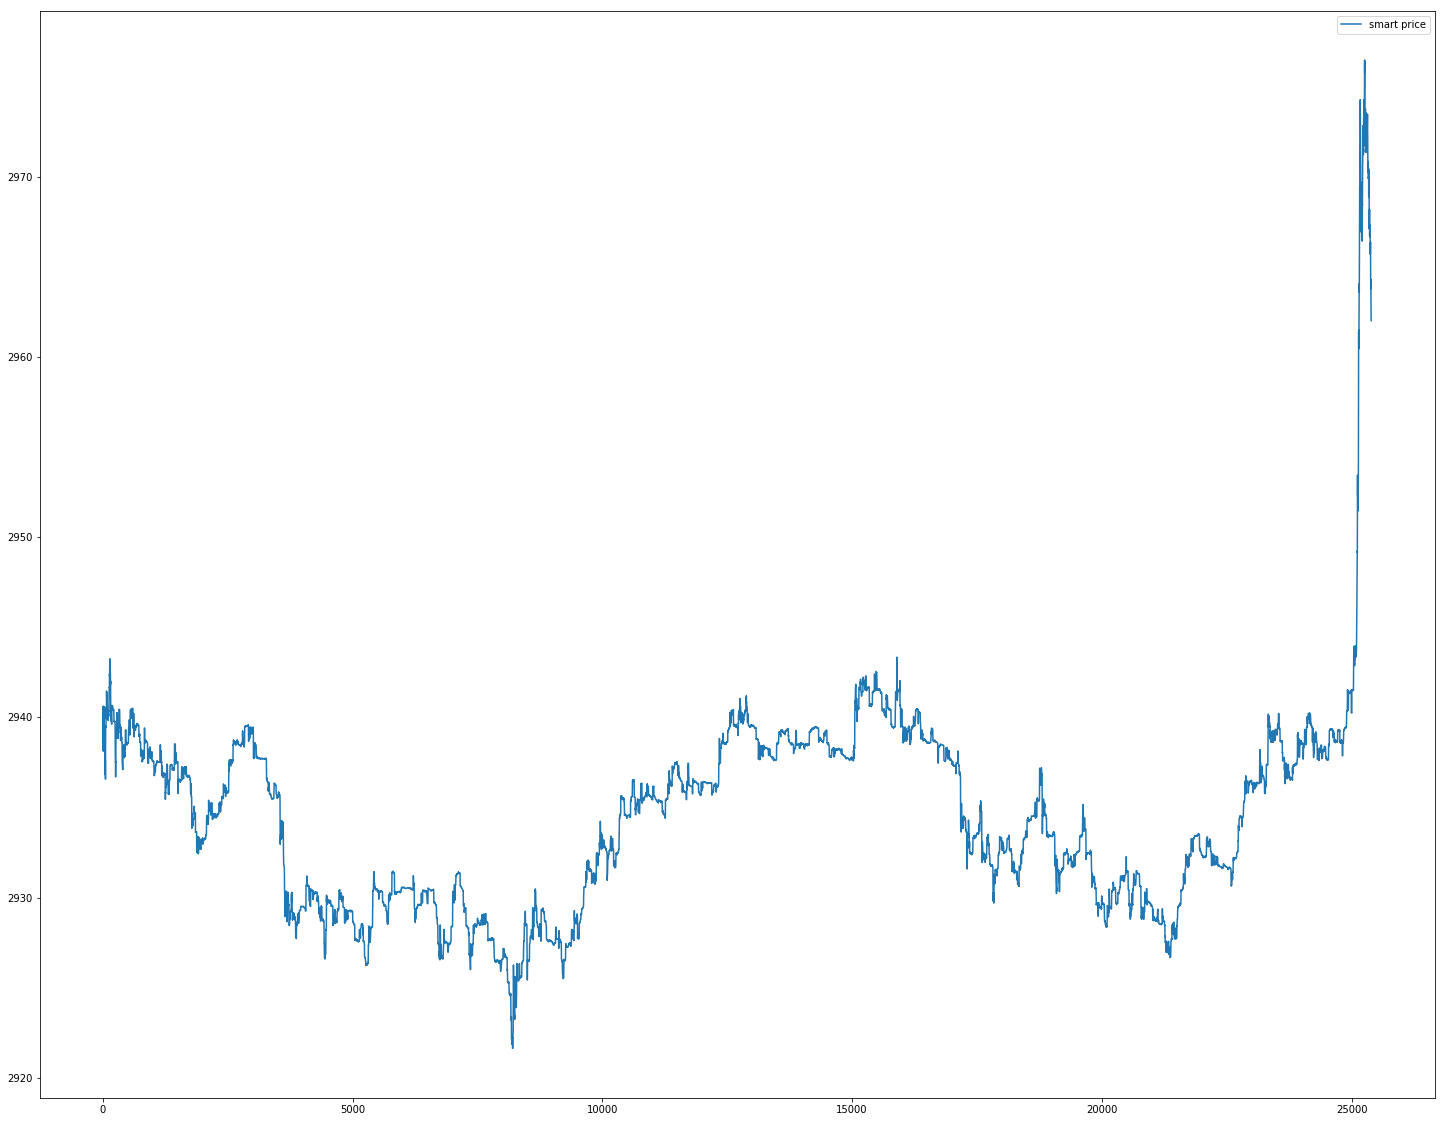

In [46]:
plt.figure(figsize=(25,20))
plt.plot(processed_1[:,-6],label='smart price')
plt.legend()
#plt.show()
plt.savefig('/Users/hudsonyeo/Desktop/Python/leo/data/day/fu/results/second/smartprice.png')